## Load Model and Evaluate Performance

This Notebook evaluates the performance of the model on the test data. It calculates the 
- UAUC
- Recall@M
- Precision@M

to compare the results to other training runs

In [1]:
import numpy as np
import tensorflow as tf
from numpy.random import seed
from tensorflow import set_random_seed
seed(1)
set_random_seed(1)

from keras import initializers
from keras.regularizers import l2
from keras.models import Model
from keras.layers import Embedding, Input, Dense, merge, Flatten, concatenate, multiply, dot, Reshape, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
import keras.callbacks
from time import time
import pdb
from scipy import sparse
import sqlalchemy as db
from sqlalchemy import create_engine
import psycopg2
import sqlite3

Using TensorFlow backend.


In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

In [3]:
import pandas as pd

In [4]:
# DATABASE_URI = ###s
# engine = create_engine(DATABASE_URI)
engine = sqlite3.connect('data/db.db',check_same_thread=False)

In [5]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [6]:
import evaluate

In [7]:
pre_tr = "data/models/training/"

### Model

In [8]:
import Hybrid_NeuMF_relu

In [9]:
# Parameters
# Model
# MLP
layers = [128,64,32,16] #[378,162,42,14]
reg_layers = [0.01, 0.01, 0.01, 0.01] #[0.04,0.0001,0.01,0.01] #
# MF
reg_mf = 0.01 #0.0003 
#num_negatives = args.num_neg
learning_rate = 0.001

In [10]:
model = Hybrid_NeuMF_relu.get_model(layers, reg_layers, reg_mf)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
weights_path = pre_tr + "4_3_relu_high_reg_weights.h5"

In [12]:
model.load_weights(weights_path)

# Evaluation

## General Auroc

Calculate the general Roc of across all users - same as selection criteria for best model

In [13]:
query = ('''SELECT  [index], userid
            FROM    target_testing_enc''')
test_data = pd.read_sql(query, engine)

In [14]:
test_list = test_data['index'].values.tolist()

In [15]:
len(test_list)

1251313

In [16]:
y_all = []
predict_all = []
for batches in range(0, len(test_list), 50000):
    indeci = tuple(test_list[batches:batches+50000])
    query_v = f"""
        SELECT * FROM target_testing_enc where [index] IN {indeci}
    """
    data = pd.read_sql_query(query_v, engine)
    data_p = evaluate.transform_log(data, 200)
    # select truth and make prediction
    y_true = data.pick.values.flatten().tolist()
    y_score = model.predict(x = data_p).flatten().tolist()
    y_all.append(y_true)
    predict_all.append(y_score)
# flatten all results
flat_list_y = [item for sublist in y_all for item in sublist]
flat_list_predict = [item for sublist in predict_all for item in sublist]
# make arrays
y_array = np.array(flat_list_y, ndmin = 2).reshape(-1,1)
pred_array = np.array(flat_list_predict, ndmin =2).reshape(-1,1)

In [17]:
flat_list_predict

[0.15979033708572388,
 0.33899274468421936,
 0.34648939967155457,
 0.346507728099823,
 0.31330883502960205,
 0.14752408862113953,
 0.4316250681877136,
 0.14850041270256042,
 0.27779263257980347,
 0.3417375683784485,
 0.2823673188686371,
 0.15036854147911072,
 0.4285244345664978,
 0.4907768964767456,
 0.32338741421699524,
 0.2906477451324463,
 0.15579360723495483,
 0.3315873146057129,
 0.3270774185657501,
 0.2020816206932068,
 0.46081990003585815,
 0.18873459100723267,
 0.1681479513645172,
 0.3217426538467407,
 0.31144705414772034,
 0.24419599771499634,
 0.3699844479560852,
 0.21317100524902344,
 0.46645495295524597,
 0.19633808732032776,
 0.3243567645549774,
 0.42184141278266907,
 0.4044645130634308,
 0.20473429560661316,
 0.2880077362060547,
 0.3529800772666931,
 0.1336059272289276,
 0.10956379771232605,
 0.4293098449707031,
 0.36661189794540405,
 0.24274370074272156,
 0.34029826521873474,
 0.3247286081314087,
 0.46809932589530945,
 0.29017147421836853,
 0.1842251718044281,
 0.2931605

In [18]:
len(flat_list_predict)

1251313

In [19]:
len(flat_list_y)

1251313

In [20]:
test_roc = roc_auc_score(y_array, pred_array)

In [21]:
test_roc

0.6343419113351525

## Results

In [22]:
results = pd.DataFrame({'index': test_list,
                        'userid': test_data.userid.values.tolist(),
                       'y_true': flat_list_y,
                       'y_pred': flat_list_predict})

In [23]:
results.head()

,index,userid,y_true,y_pred
0,0,1677343,1.0,0.159790
1,1,1677430,0.0,0.338993
2,2,1657316,0.0,0.346489
3,3,1657316,0.0,0.346508
4,4,1564925,1.0,0.313309


In [24]:
np.mean(y_true)

0.428027418126428

## Per User Metrics

### Evaluate User - AUROC

Calculate AUROC for each user and avg the result

In [25]:
users = results.userid.unique().tolist()

In [26]:
len(users)

33867

In [27]:
all_user_roc = []
clicks = []
for u in users: 
    data_u = results[results.userid == u].reset_index(drop=True)
    clicks.append(len(data_u))
    if len(data_u.y_true.unique()) > 1:
        roc = roc_auc_score(data_u.y_true, data_u.y_pred)
    else:
        roc = None
    all_user_roc.append(roc)

In [28]:
len(all_user_roc)

33867

In [29]:
# delete users that did not have a valid roc auc score
all_roc_clean = [x for x in all_user_roc if not pd.isnull(x)]
user_roc = sum(all_roc_clean) / len(all_roc_clean)

In [30]:
len(all_roc_clean)

22458

In [31]:
user_roc

0.6454181896322839

In [32]:
import statistics

In [33]:
statistics.median(all_roc_clean)

0.6625000000000001

In [34]:
user_stats = pd.DataFrame({'userid': users, 
                          'roc': all_user_roc})

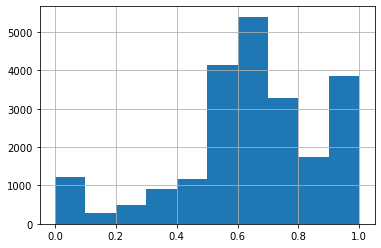

In [35]:
user_stats.roc.hist()

### Evaluate Precision@k per User

In [36]:
from sklearn.metrics import precision_score

In [37]:
k = 5

In [38]:
all_user_prec = []

In [39]:
for u in users:
    data_u = results[results.userid == u].reset_index(drop=True)
    data_u_top = data_u.sort_values('y_pred', ascending = False)[:k]
    prec = precision_score(data_u_top.y_true.values.reshape(-1,1), data_u_top.y_pred.values.reshape(-1,1).round())
    all_user_prec.append(prec)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
avg_precision = sum(all_user_prec) / len(all_user_prec)
avg_precision

0.16254958120490962

In [41]:
user_stats['precision'] = all_user_prec

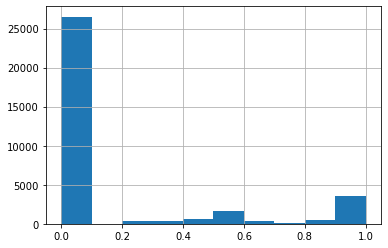

In [42]:
user_stats.precision.hist()

### Evaluate Recall@k per User

In [43]:
all_recall = []

In [44]:
for u in users:
    data_u = results[results.userid == u].reset_index(drop=True)
    data_u_top = data_u.sort_values('y_pred', ascending = False)[:k]
    recall = recall_score(data_u_top.y_true.values.reshape(-1,1), data_u_top.y_pred.values.reshape(-1,1).round())
    all_recall.append(recall)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [45]:
avg_recall = sum(all_recall)/len(all_recall)
avg_recall

0.1555314416196682

In [46]:
user_stats['recall'] = all_recall

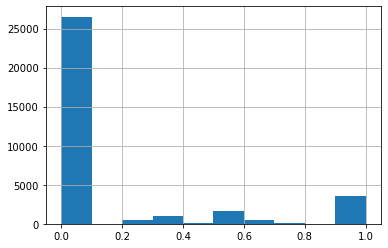

In [47]:
user_stats.recall.hist()